# Amazon Product Review

## Load Libraries

In [118]:
!pip install nltk


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [168]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from itertools import product

## Data Extraction

In [120]:
df = pd.read_csv("Amazon.csv")
df.head(3)

,id,asins,brand,categories,colors,dateAdded,dateUpdated,dimension,ean,keys,...,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.userCity,reviews.userProvince,reviews.username,sizes,upc,weight
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I initially had trouble deciding between the p...,"Paperwhite voyage, no regrets!",NaN,NaN,Cristina M,NaN,NaN,205 grams
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,5.0,https://www.amazon.com/Kindle-Paperwhite-High-...,Allow me to preface this with a little history...,One Simply Could Not Ask For More,NaN,NaN,Ricky,NaN,NaN,205 grams
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,Amazon,"Amazon Devices,mazon.co.uk",NaN,2016-03-08T20:21:53Z,2017-07-18T23:52:58Z,169 mm x 117 mm x 9.1 mm,NaN,kindlepaperwhite/b00qjdu3ky,...,4.0,https://www.amazon.com/Kindle-Paperwhite-High-...,I am enjoying it so far. Great for reading. Ha...,Great for those that just want an e-reader,NaN,NaN,Tedd Gardiner,NaN,NaN,205 grams


In [121]:
df.shape

(1597, 27)

In [122]:
def df_info(df):
    print("Shape of dataframe: ", df.shape)
    print("Nan values: ", df.isna().sum().sum())
    print("Duplicate values: ", df.duplicated(keep= False).sum())
df_info(df)

Shape of dataframe:  (1597, 27)
Nan values:  12871
Duplicate values:  0


In [123]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    1597 non-null   object 
 1   asins                 1597 non-null   object 
 2   brand                 1597 non-null   object 
 3   categories            1597 non-null   object 
 4   colors                774 non-null    object 
 5   dateAdded             1597 non-null   object 
 6   dateUpdated           1597 non-null   object 
 7   dimension             565 non-null    object 
 8   ean                   898 non-null    float64
 9   keys                  1597 non-null   object 
 10  manufacturer          965 non-null    object 
 11  manufacturerNumber    902 non-null    object 
 12  name                  1597 non-null   object 
 13  prices                1597 non-null   object 
 14  reviews.date          1217 non-null   object 
 15  reviews.doRecommend  

In [124]:
for col in df:
    percentage = df[col].isna().sum() / df.shape[0] *100
    print(f'{col} : {percentage}')

id : 0.0
asins : 0.0
brand : 0.0
categories : 0.0
colors : 51.534126487163434
dateAdded : 0.0
dateUpdated : 0.0
dimension : 64.6211646837821
ean : 43.76956793988729
keys : 0.0
manufacturer : 39.5742016280526
manufacturerNumber : 43.51909830933
name : 0.0
prices : 0.0
reviews.date : 23.794614902943017
reviews.doRecommend : 66.2492172824045
reviews.numHelpful : 43.64433312460864
reviews.rating : 26.29931120851597
reviews.sourceURLs : 0.0
reviews.text : 0.0
reviews.title : 1.0644959298685035
reviews.userCity : 100.0
reviews.userProvince : 100.0
reviews.username : 1.0644959298685035
sizes : 100.0
upc : 43.76956793988729
weight : 57.04445835942392


In [125]:
df.columns

Index(['id', 'asins', 'brand', 'categories', 'colors', 'dateAdded',
       'dateUpdated', 'dimension', 'ean', 'keys', 'manufacturer',
       'manufacturerNumber', 'name', 'prices', 'reviews.date',
       'reviews.doRecommend', 'reviews.numHelpful', 'reviews.rating',
       'reviews.sourceURLs', 'reviews.text', 'reviews.title',
       'reviews.userCity', 'reviews.userProvince', 'reviews.username', 'sizes',
       'upc', 'weight'],
      dtype='object')

## Preprocessing

In [126]:
df.drop(columns=['sizes','upc', 'weight','reviews.userCity', 'dimension', "keys", "manufacturer", "ean","manufacturerNumber",
                 "brand", "colors", "reviews.date","reviews.sourceURLs", "dateAdded", "dateUpdated", "reviews.userProvince",
                 "reviews.doRecommend", "reviews.numHelpful"], inplace=True, errors="ignore")

In [127]:
df["prices"].iloc[10]


'[{"amountMax":139.99,"amountMin":139.99,"currency":"USD","dateAdded":"2017-07-18T23:52:58Z","dateSeen":["2017-07-15T18:10:23.807Z","2016-03-16T00:00:00Z"],"isSale":"false","merchant":"Amazon.com","shipping":"FREE Shipping.","sourceURLs":["https://www.amazon.com/Kindle-Paperwhite-High-Resolution-Display-Built/dp/B00QJDU3KY/ref=lp_6669702011_1_7/132-1677641-8459202?s=amazon-devices&ie=UTF8&qid=1498832761&sr=1-7","http://www.amazon.com/Kindle-Paperwhite-High-Resolution-Display-Built-/dp/B00QJDU3KY"]},{"amountMax":119.99,"amountMin":119.99,"condition":"new","currency":"EUR","dateAdded":"2016-03-08T20:21:53Z","dateSeen":["2016-01-29T00:00:00Z"],"isSale":"false","merchant":"Amazon EU Sarl","shipping":"free","sourceURLs":["http://www.amazon.co.uk/Kindle-Paperwhite-Resolution-Display-Built-/dp/B00QJDU3KY"]},{"amountMax":139.99,"amountMin":139.99,"condition":"new","currency":"CAD","dateAdded":"2016-03-08T20:21:53Z","dateSeen":["2016-01-11T00:00:00Z"],"isSale":"false","merchant":"Amazon","shipp

In [128]:
df["categories"].iloc[0]

'Amazon Devices,mazon.co.uk'

In [129]:
df["categories"].iloc[500]

'Amazon Devices,Kindle Store'

In [130]:
df.rename(columns={
    "reviews.username": "user_id",
    "asins": "product_id",
    "reviews.rating": "rating",
}, inplace=True)

In [131]:
for col in df:
    percentage = df[col].isna().sum() / df.shape[0] *100
    print(f'{col} : {percentage}')

id : 0.0
product_id : 0.0
categories : 0.0
name : 0.0
prices : 0.0
rating : 26.29931120851597
reviews.text : 0.0
reviews.title : 1.0644959298685035
user_id : 1.0644959298685035


In [132]:
df.dropna(subset=["reviews.title", "user_id"], inplace=True)

In [133]:
rating_mean = (df["rating"].mean())

In [134]:
df["rating"] = df["rating"].fillna(rating_mean)

In [135]:
for col in df:
    percentage = df[col].isna().sum() / df.shape[0] *100
    print(f'{col} : {percentage}')

id : 0.0
product_id : 0.0
categories : 0.0
name : 0.0
prices : 0.0
rating : 0.0
reviews.text : 0.0
reviews.title : 0.0
user_id : 0.0


In [136]:
import json

df["price"] = df["prices"].apply(lambda x: json.loads(x)[0]["amountMin"])

In [137]:
df.drop(columns=["prices"], inplace=True)

In [138]:
df.tail(3)

,id,product_id,categories,name,rating,reviews.text,reviews.title,user_id,price
1594,AVpfo9ukilAPnD_xfhuj,B00NO8JJZW,"Amazon Devices & Accessories,Amazon Device Acc...",Alexa Voice Remote for Amazon Fire TV and Fire...,1.0,"Remote did not activate, nor did it connect to...",replacing an even worse remote. Waste of time,Amazon Customer,29.99
1595,AVpfo9ukilAPnD_xfhuj,B00NO8JJZW,"Amazon Devices & Accessories,Amazon Device Acc...",Alexa Voice Remote for Amazon Fire TV and Fire...,3.0,It does the job but is super over priced. I fe...,Overpriced,Meg Ashley,29.99
1596,AVpfo9ukilAPnD_xfhuj,B00NO8JJZW,"Amazon Devices & Accessories,Amazon Device Acc...",Alexa Voice Remote for Amazon Fire TV and Fire...,1.0,I ordered this item to replace the one that no...,I am sending all of this crap back to amazon a...,DIANE K,29.99


In [139]:
df.columns

Index(['id', 'product_id', 'categories', 'name', 'rating', 'reviews.text',
       'reviews.title', 'user_id', 'price'],
      dtype='object')

In [140]:
df.drop(columns=["reviews.title"], inplace=True)

In [141]:
df["rating"].unique()

array([5.        , 4.        , 4.35938828, 3.        , 1.        ,
       2.        ])

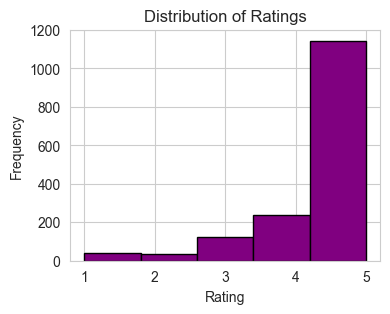

In [142]:
plt.figure(figsize=(4,3))
plt.hist(df['rating'], bins= 5, edgecolor='black', color="purple")
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [143]:
df.iloc[100]

id                                           AV00lzP7GV-KLJ3ac0uk
product_id                                             B01LW1MS9C
categories                                         Amazon Devices
name            Amazon Echo Dot Case (fits Echo Dot 2nd Genera...
rating                                                        5.0
reviews.text    A great looking cover for the Echo Dot. It giv...
user_id                                                 C. Morrow
price                                                       14.99
Name: 100, dtype: object

In [144]:
df["user_id"][10:20]

10          Miguel Martinez
11        Magnus Brattemark
12            Tedd Gardiner
13       Janet Matthews Jan
14    John Kat's the brains
15                   samira
16             Louis simard
17                   JanetC
18                 Shepherd
19                   Brenda
Name: user_id, dtype: object

In [145]:
df["user_id"] = (
    df["user_id"]
    .str.lower()
    .str.strip()
    .str.replace(" ", "_")
)

In [146]:
print(f'{"price min: "} {df["price"].min()}')
print(f'{"price max: "} {df["price"].max()}')
print(f'{"price max: "} {df["price"].mean()}')

price min:  9.99
price max:  464.0
price max:  95.82608227848101


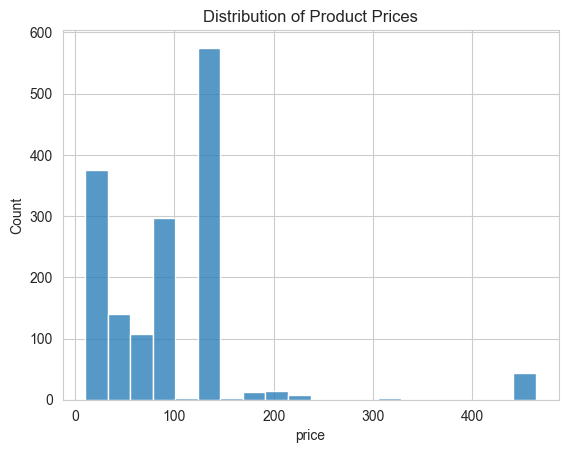

In [147]:
sns.histplot(df['price'], bins=20)
plt.title('Distribution of Product Prices')
plt.show()

In [148]:
df["categories"].unique()

array(['Amazon Devices,mazon.co.uk',
       'Kindle Store,Amazon Devices,Electronics',
       'Categories,Amazon Devices,Streaming Media Players',
       'Amazon Devices',
       'Categories,Amazon Devices,Electronics Features,Streaming Media Players,Consumer Electronics,See more Amazon Fire TV Digital HD Media Streamer (Late...',
       'Amazon Devices & Accessories,Amazon Device Accessories,Power Adapters & Cables,Kindle Store,Kindle E-Reader Accessories,Kindle Paperwhite Accessories',
       'Amazon Devices,Kindle Store', 'Electronics,Amazon Devices',
       'Amazon Devices,Kindle Accessories',
       'Amazon Devices,Electronics,Kindle Store',
       'Amazon Devices,Electronics,Kindle Store,Amazon Echo',
       'Amazon Devices,Kindle Store,Kindle Accessories',
       'Amazon Devices,Kindle Store,buy a kindle',
       'Amazon Devices,Home,Smart Home & Connected Living,Smart Hubs & Wireless Routers,Smart Hubs,Home Improvement,Home Safety & Security,Alarms & Sensors,Home Security,Amazo

In [149]:
df["categories"] = df["categories"].str.lower()
df["categories"] = df["categories"].replace("&",",")
df['categories'] = df['categories'].str.replace(r'\s*,\s*', ',', regex=True)  # استاندارد کردن کاما
df['categories'] = df['categories'].str.replace(r',,+', ',', regex=True)       # کامای چندتا
df['categories'] = df['categories'].str.replace(r'^,|,$', '', regex=True)     # کاما اول و آخر
df['categories'] = df['categories'].str.strip()

In [150]:
df["categories"].unique()

array(['amazon devices,mazon.co.uk',
       'kindle store,amazon devices,electronics',
       'categories,amazon devices,streaming media players',
       'amazon devices',
       'categories,amazon devices,electronics features,streaming media players,consumer electronics,see more amazon fire tv digital hd media streamer (late...',
       'amazon devices & accessories,amazon device accessories,power adapters & cables,kindle store,kindle e-reader accessories,kindle paperwhite accessories',
       'amazon devices,kindle store', 'electronics,amazon devices',
       'amazon devices,kindle accessories',
       'amazon devices,electronics,kindle store',
       'amazon devices,electronics,kindle store,amazon echo',
       'amazon devices,kindle store,kindle accessories',
       'amazon devices,kindle store,buy a kindle',
       'amazon devices,home,smart home & connected living,smart hubs & wireless routers,smart hubs,home improvement,home safety & security,alarms & sensors,home security,amazo

In [151]:
df.drop(columns=["user_id"], inplace=True)

In [152]:
df.head()

,id,product_id,categories,name,rating,reviews.text,price
0,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,"amazon devices,mazon.co.uk",Kindle Paperwhite,5.0,I initially had trouble deciding between the p...,139.99
1,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,"amazon devices,mazon.co.uk",Kindle Paperwhite,5.0,Allow me to preface this with a little history...,139.99
2,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,"amazon devices,mazon.co.uk",Kindle Paperwhite,4.0,I am enjoying it so far. Great for reading. Ha...,139.99
3,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,"amazon devices,mazon.co.uk",Kindle Paperwhite,5.0,I bought one of the first Paperwhites and have...,139.99
4,AVpe7AsMilAPnD_xQ78G,B00QJDU3KY,"amazon devices,mazon.co.uk",Kindle Paperwhite,5.0,I have to say upfront - I don't like coroporat...,139.99


In [153]:
df["reviews.text"].iloc[10]

"As reviewed by the wife This is the perfect thing for a new mommy who loves to read books! As soon as I had my baby girl, I had to stop reading my novels because I had to give the baby my full attention. But how much time do I spend laying in bed, on my side, with the baby while she feeds Especially prior to 4 months when feeding took as long as 45 minutes! Not to mention cluster feeds during growth spurts! A book was out of the question because it's sooo tiring to hold up in side-lying-breastfeeding-position. My new Kindle was the solution! It's light, easy to disinfect (I use baby wipes on the case whenever I feel like it's not clean enough to go on the bed with the baby) and you don't need to keep a finger in the middle of the pages to keep it from closing - you know what I mean!And for some reason it's much easier to go through a book with a Kindle compared to an actual book. I never thought I'd be converted into the Kindle culture but here we are!"

In [154]:
df["reviews.text"] = df["reviews.text"].str.lower()


In [155]:
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text_series):
    text_series = text_series.str.lower()
    text_series = text_series.apply(lambda x: re.sub(r'[^a-z\s]', '', x))
    text_series = text_series.apply(lambda x: re.sub(r'\s+', ' ', x).strip())
    text_series = text_series.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

    return text_series

df['reviews.text'] = clean_text(df['reviews.text'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [156]:
df['reviews.text'].iloc[10]

'reviewed wife perfect thing new mommy loves read books soon baby girl stop reading novels give baby full attention much time spend laying bed side baby feeds especially prior months feeding took long minutes mention cluster feeds growth spurts book question sooo tiring hold sidelyingbreastfeedingposition new kindle solution light easy disinfect use baby wipes case whenever feel like clean enough go bed baby dont need keep finger middle pages keep closing know meanand reason much easier go book kindle compared actual book never thought id converted kindle culture'

In [157]:
df.tail(3)

,id,product_id,categories,name,rating,reviews.text,price
1594,AVpfo9ukilAPnD_xfhuj,B00NO8JJZW,"amazon devices & accessories,amazon device acc...",Alexa Voice Remote for Amazon Fire TV and Fire...,1.0,remote activate connect boxa poorly designed r...,29.99
1595,AVpfo9ukilAPnD_xfhuj,B00NO8JJZW,"amazon devices & accessories,amazon device acc...",Alexa Voice Remote for Amazon Fire TV and Fire...,3.0,job super priced feel like offer replacement r...,29.99
1596,AVpfo9ukilAPnD_xfhuj,B00NO8JJZW,"amazon devices & accessories,amazon device acc...",Alexa Voice Remote for Amazon Fire TV and Fire...,1.0,ordered item replace one longer works directio...,29.99


In [158]:
#Group by product_id to remove duplicates and aggregate reviews
print("Shape before grouping:", df.shape)

df_grouped = df.groupby('product_id').agg({
    'id': 'first',
    'name': 'first',
    'categories': 'first',
    'price': 'mean',
    'rating': 'mean',
    'reviews.text': lambda x: ' '.join(x.unique())
}).reset_index()

print("Shape after grouping:", df_grouped.shape)
print("Unique products:", df_grouped['product_id'].nunique())

df = df_grouped.copy()

Shape before grouping: (1580, 7)
Shape after grouping: (54, 7)
Unique products: 54


## Model Selection

In [159]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [160]:
df.columns

Index(['product_id', 'id', 'name', 'categories', 'price', 'rating',
       'reviews.text'],
      dtype='object')

In [161]:
scaler = MinMaxScaler()
price_scaled = scaler.fit_transform(df[['price']])

In [162]:
vectorizer = TfidfVectorizer()
cat_vectorizer = vectorizer.fit_transform(df["categories"])


In [163]:
vectorizer = TfidfVectorizer()
review_vectorizer = vectorizer.fit_transform(df["reviews.text"])

In [164]:
sim_text = cosine_similarity(review_vectorizer)
sim_cat  = cosine_similarity(cat_vectorizer)
sim_price = cosine_similarity(price_scaled)

In [165]:
weights = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

combinations = [(wt, wc, wp) for wt in weights for wc in weights for wp in weights
                if abs(wt + wc + wp - 1.0) < 1e-6]

print(f"Testing {len(combinations)} weight combinations...")

best_precision = 0
best_weights = None
results = []

for w_text, w_cat, w_price in combinations:
    hybrid_sim_temp = w_text * sim_text + w_cat * sim_cat + w_price * sim_price

    precision, recall = evaluate_recommender(hybrid_sim_temp, test_df, K=5)

    results.append({
        'weights': (w_text, w_cat, w_price),
        'precision': precision,
        'recall': recall
    })

    if precision > best_precision:
        best_precision = precision
        best_weights = (w_text, w_cat, w_price)

print("\n=== Best Weights Found ===")
print(f"Text: {best_weights[0]}, Categories: {best_weights[1]}, Price: {best_weights[2]}")
print(f"Best Precision@5: {best_precision:.4f}")

hybrid_sim = (best_weights[0] * sim_text +
              best_weights[1] * sim_cat +
              best_weights[2] * sim_price)

Testing 36 weight combinations...
Evaluation on 9 items
Mean Precision@5: 0.0000
Mean Recall@5:    0.0000
Evaluation on 9 items
Mean Precision@5: 0.0000
Mean Recall@5:    0.0000
Evaluation on 9 items
Mean Precision@5: 0.0000
Mean Recall@5:    0.0000
Evaluation on 9 items
Mean Precision@5: 0.0000
Mean Recall@5:    0.0000
Evaluation on 9 items
Mean Precision@5: 0.0000
Mean Recall@5:    0.0000
Evaluation on 9 items
Mean Precision@5: 0.0000
Mean Recall@5:    0.0000
Evaluation on 9 items
Mean Precision@5: 0.0000
Mean Recall@5:    0.0000
Evaluation on 9 items
Mean Precision@5: 0.0000
Mean Recall@5:    0.0000
Evaluation on 9 items
Mean Precision@5: 0.0444
Mean Recall@5:    0.0370
Evaluation on 9 items
Mean Precision@5: 0.0000
Mean Recall@5:    0.0000
Evaluation on 9 items
Mean Precision@5: 0.0000
Mean Recall@5:    0.0000
Evaluation on 9 items
Mean Precision@5: 0.0000
Mean Recall@5:    0.0000
Evaluation on 9 items
Mean Precision@5: 0.0000
Mean Recall@5:    0.0000
Evaluation on 9 items
Mean Pre

## Test & Evaluate

In [169]:
def recommend(product_idx, top_k=5):
    product = df.iloc[product_idx]
    print("Original Product:")
    print(f"Name     : {product['name']}")
    print(f"Price    : ${product['price']:.2f}")
    print(f"Rating   : {product['rating']:.2f}")
    print(f"Categories: {product['categories'][:100]}...\n")

    print("Recommended Products:")
    sim_scores = hybrid_sim[product_idx]
    top_indices = np.argsort(sim_scores)[::-1][1:top_k+1]

    recommendations = df.iloc[top_indices][['name', 'price', 'rating']].copy()
    recommendations['similarity_score'] = sim_scores[top_indices]
    return recommendations

In [170]:
recommend(0, top_k=5)

Original Product:
Name     : Kindle Keyboard
Price    : $79.99
Rating   : 4.29
Categories: kindle store,amazon devices,electronics...

Recommended Products:


,name,price,rating,similarity_score
1,Kindle,79.00,4.437511,0.852927
4,Kindle Paperwhite,19.99,4.500000,0.782263
2,"Kindle Fire HD 7""",59.99,4.376153,0.776544
10,Certified Refurbished Kindle E-reader,69.00,4.513027,0.759220
32,Kindle E-reader - Black,79.99,5.000000,0.758397


In [166]:
def evaluate_recommender(hybrid_sim, df, K=5):
    precisions = []
    recalls = []
    valid_count = 0

    for idx in range(len(df)):
        current_cat = df.iloc[idx]['categories']
        current_rating_threshold = df.iloc[idx]['rating']

        relevant_mask = (
            (df['categories'] == current_cat) &
            (df['rating'] >= 4.0) &
            (df.index != idx)
        )
        relevant_indices = df[relevant_mask].index.tolist()

        if len(relevant_indices) == 0:
            continue

        valid_count += 1

        sim_scores = hybrid_sim[idx]
        top_indices = np.argsort(sim_scores)[::-1][1:K+1]

        recommended_set = set(top_indices)
        relevant_set = set(relevant_indices)
        true_positives = recommended_set.intersection(relevant_set)

        precision = len(true_positives) / K
        recall = len(true_positives) / len(relevant_indices) if relevant_indices else 0

        precisions.append(precision)
        recalls.append(recall)

    if valid_count == 0:
        print("No valid items for evaluation!")
        return 0, 0

    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)

    print(f"Evaluation on {valid_count} items")
    print(f"Mean Precision@ {K}: {mean_precision:.4f}")
    print(f"Mean Recall@{K}:    {mean_recall:.4f}")

    return mean_precision, mean_recall

In [167]:
precision, recall = evaluate_recommender(hybrid_sim, test_df, K=5)

Evaluation on 9 items
Mean Precision@5: 0.0667
Mean Recall@5:    0.0556
